In [1]:
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos.
import pandas as pd
import os
import warnings

from pathlib import Path
from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.

#!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer 
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

# **Anime recommendation**

## **Carga de datos**

En esta celda cargamos el csv de anime

In [2]:
#Anime.csv
path = Path(os.getcwd())
path = str(path.parent.absolute())
path = path+"/datos/anime.csv"
dfAnime = pd.read_csv(path,na_values='?')    
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [3]:
#rating.csv
path2 = Path(os.getcwd())
path2 = str(path2.parent.absolute())
path2 = path2+"/datos/rating.csv"
dfRating = pd.read_csv(path2,na_values='?')    
dfRating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## **Tipos de dato adecuados**

In [4]:
#anime.csv
dfAnime['name'] = dfAnime['name'].astype("string")
dfAnime['genre'] = dfAnime['genre'].astype("string")
dfAnime['type'] = dfAnime['type'].astype("string")
dfAnime['episodes']=pd.to_numeric(dfAnime.episodes, errors='coerce').dropna().astype(int)
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  11954 non-null  float64
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(2), int64(2), string(3)
memory usage: 672.5 KB


 **rating.csv ya tenia los tipos de datos adecuados**

## **Busqueda y eliminacion de valores nulos o duplicados**

### anime.csv

In [5]:
nullValues = []

for i in range(len(dfAnime)):
    if(dfAnime.iloc[i].isnull().sum() != 0):
        nullValues.append(i)
print("Se encontraron ",len(nullValues)," valores nulos")
#La cantidad de datos con valores nulos no es tan grande en comparacion asi que podemos borrarlos
#Unknown es contado como nulo porque no podemos asumir la cantidad de episodios de un anime en base a otros

Se encontraron  464  valores nulos


In [6]:
dfAnime=dfAnime.drop(nullValues)
dfAnime['episodes'] = dfAnime['episodes'].astype(int)
dfAnime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11830 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11830 non-null  int64  
 1   name      11830 non-null  string 
 2   genre     11830 non-null  string 
 3   type      11830 non-null  string 
 4   episodes  11830 non-null  int32  
 5   rating    11830 non-null  float64
 6   members   11830 non-null  int64  
dtypes: float64(1), int32(1), int64(2), string(3)
memory usage: 693.2 KB


In [7]:
duplicados = dfAnime[dfAnime.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


In [8]:
#Convirtamos type en una variable de numeros enteros para poder usar histogramas a futuro
dfAnime=dfAnime.replace({'Movie': '0', 'TV': '1','OVA':'2','ONA':'2','Special':'3','Music':'4'})
dfAnime['type'] = dfAnime['type'].astype(int)

In [9]:
dfAnime.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",1,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",1,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",1,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",1,51,9.16,151266


In [39]:
genreCount = dfAnime[["genre"]]
genreCount["genre"] = genreCount["genre"].str.split(", | , | ,")
genreCount = genreCount.explode("genre")
genreCount["genre"] = genreCount["genre"].str.title()

print(f'Total unique genres are {len(genreCount["genre"].unique())}')
print(f'Occurances of unique genres :')
genreCount["genre"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Total unique genres are 44
Occurances of unique genres :


,Comedy,Action,Adventure,Fantasy,Sci-Fi,Drama,Shounen,Kids,Romance,Slice Of Life,School,Hentai,Supernatural,Mecha,Historical,Magic,Ecchi,Shoujo,Music,Seinen,Sports,Mystery,Super Power,Military,Parody,Space,Horror,Harem,4,Demons,Martial Arts,Dementia,Psychological,Police,Game,Samurai,Vampire,Thriller,Cars,Shounen Ai,Shoujo Ai,Josei,Yuri,Yaoi
genre,4483,2748,2293,2219,2028,1972,1669,1550,1436,1180,1164,1099,993,927,787,742,627,587,535,530,527,482,445,415,397,376,360,312,297,287,258,238,226,194,170,145,100,86,71,62,54,52,41,37


In [138]:
def createNewColumn(colname):
    dfAnime[colname] = np.where(dfAnime.genre.str.contains(colname),1,0)
    dfAnime[colname] = dfAnime[colname].astype(category)

In [124]:
def containsGenre(dfInfo,word):  
    if str(dfAnime["genre"]).find(word):
        return 1
    return 0

In [139]:
#Partir aqui las categorias
for i in range(15):
    print(genreCount["genre"].value_counts().index.tolist()[i])
    createNewColumn(genreCount["genre"].value_counts().index.tolist()[i])

#df['colF'] = df.apply(lambda row: categorise(row), axis=1)

Comedy


NameError: name 'category' is not defined

In [137]:
dfAnime.head(5)

,anime_id,name,genre,type,episodes,rating,members,Comedy,Action,Adventure,...,Drama,Shounen,Kids,Romance,Slice Of Life,School,Hentai,Supernatural,Mecha,Historical
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,1,9.37,200630,0,0,0,...,1,0,0,1,0,1,0,1,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",1,64,9.26,793665,0,1,1,...,1,1,0,0,0,0,0,0,0,0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",1,51,9.25,114262,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,9253,Steins;Gate,"Sci-Fi, Thriller",1,24,9.17,673572,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",1,51,9.16,151266,1,1,0,...,0,1,0,0,0,0,0,0,0,1


### rating.csv

In [13]:
print("La cantidad de datos nulos es:")
dfRating.isna().sum().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

La cantidad de datos nulos es:


,user_id,anime_id,rating
0,0,0,0


In [14]:
#Eliminamos los -1 porque indican cuando no se califico un anime y siendo asi entonces no nos sirve
dfRating = dfRating[dfRating.rating != -1]

In [15]:
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  1


In [16]:
dfRating.drop_duplicates(keep='first',inplace=True)
duplicados = dfRating[dfRating.duplicated()].shape[0]
print("Numero de datos duplicados ",duplicados)

Numero de datos duplicados  0


In [17]:
dfRating.head(5)

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [18]:
dfRating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337240 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB


## **Histogramas**

array([[<AxesSubplot:title={'center':'type'}>]], dtype=object)

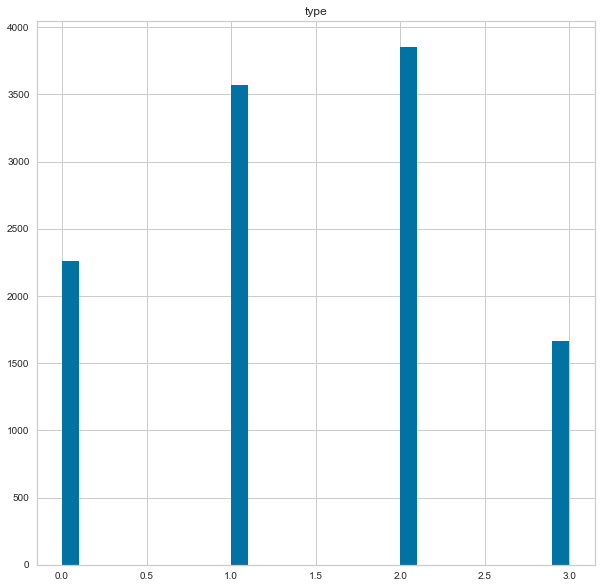

In [19]:
#Generemos algunas gráficas directamente desde pandas.
atr = 'type'
num_bins = 30 #Número de columnas del histograma
dfAnime.hist(column=atr,range=[0, 3], bins=num_bins, figsize=(10,10))  #Histograma.

+ Observamos que aquellos tipos de anime que mas aparecen son "TV" y "OVA"

array([[<AxesSubplot:title={'center':'episodes'}>]], dtype=object)

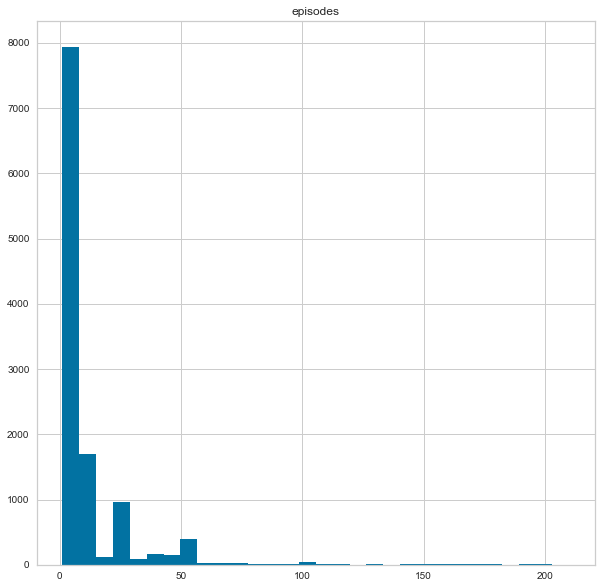

In [20]:
#Generemos algunas gráficas directamente desde pandas.
atr = 'episodes'
num_bins = 30 #Número de columnas del histograma
dfAnime.hist(column=atr,range=[1, 210], bins=num_bins, figsize=(10,10))  #Histograma.

+ Como se puede observar hay una gran cantidad de valores en 1, esto es debido a que muchos de los animes son peliculas u ovas por lo que solo cuentan con un episodio tecnicamente

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

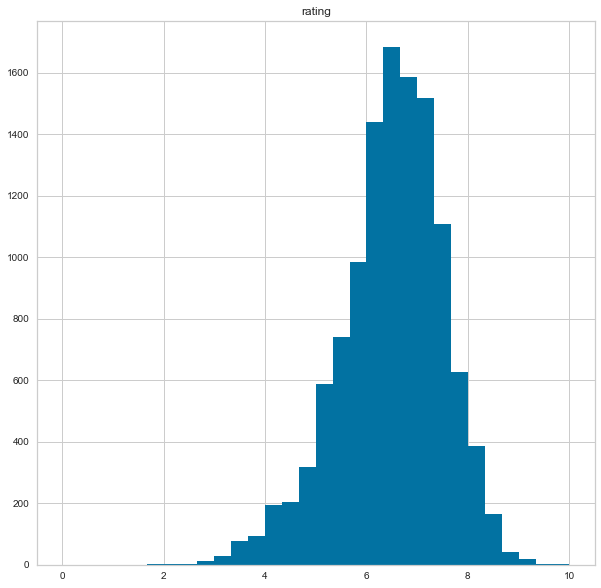

In [21]:
#Generemos algunas gráficas directamente desde pandas.
atr = 'rating'
num_bins = 30 #Número de columnas del histograma
dfAnime.hist(column=atr,range=[0, 10], bins=num_bins, figsize=(10,10))  #Histograma.

+ Entre 6 y 7 estan la mayoria de ratings

array([[<AxesSubplot:title={'center':'members'}>]], dtype=object)

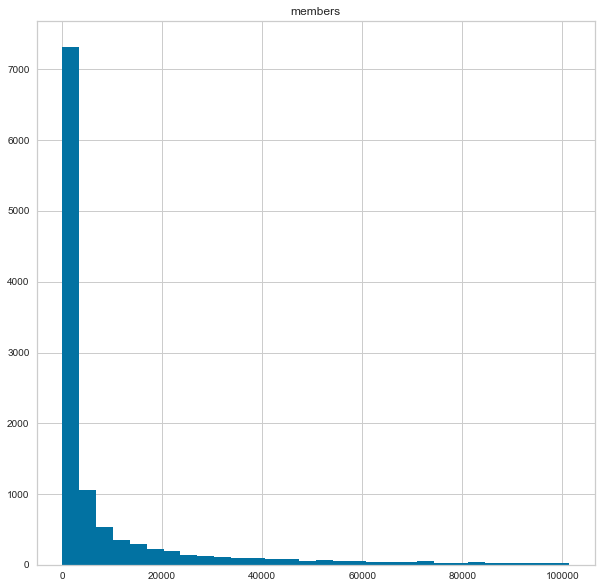

In [22]:
#Generemos algunas gráficas directamente desde pandas.
atr = 'members'
num_bins = 30 #Número de columnas del histograma
dfAnime.hist(column=atr,range=[5, 101397], bins=num_bins, figsize=(10,10))
#El rango es demasiado amplio, debemos disminuir el rango

array([[<AxesSubplot:title={'center':'members'}>]], dtype=object)

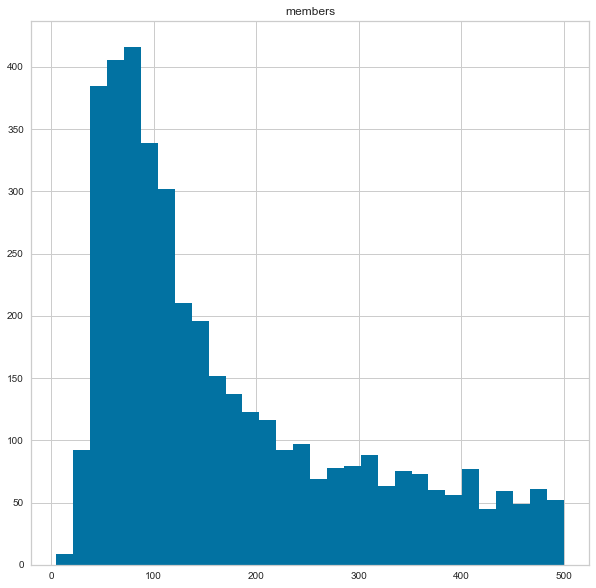

In [23]:
atr = 'members'
num_bins = 30 #Número de columnas del histograma
dfAnime.hist(column=atr,range=[5, 500], bins=num_bins, figsize=(10,10))

+ Tener entre 20 y 80 miembros es lo mas comun para la mayoria de animes

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

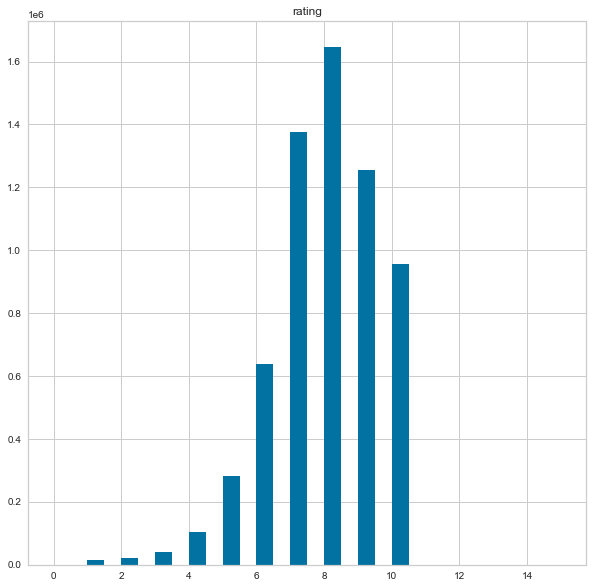

In [24]:
atr = 'rating'
num_bins = 30 #Número de columnas del histograma
dfRating.hist(column=atr,range=[0, 15], bins=num_bins, figsize=(10,10))

+ La mayoria de usuarios puntua 8 a los animes

## **Busqueda y eliminacion de outliers**

Dada la naturaleza de las variables involucradas, solo tiene sentido analizar los outliers de los episodios y los miembros

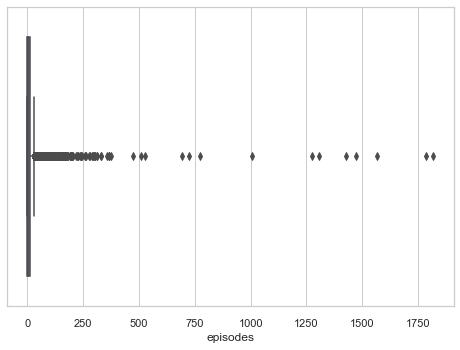

In [25]:
atr = 'episodes'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=dfAnime[atr])

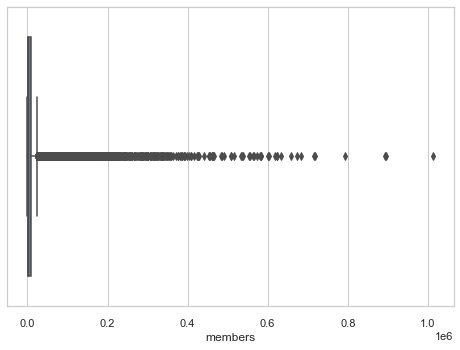

In [26]:
atr = 'members'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=dfAnime[atr])

Se debe tener en cuenta que la base de datos cuenta con animes de todo tipo incluyendo peliculas, esto significa que muchos de los datos se veran alterados por esto, por ejemplo, la cantidad de episodios tiende a ser 1 si el anime es del tipo pelicula mientras que las series pueden llegar incluso a 100 episodios.

Por ello, es apropiado partir el dataframe en 2, uno para series de anime normales y otro para peliculas, ovas, etc.

In [27]:
df_series = dfAnime.loc[dfAnime['type'] == 1]
df_other_content = dfAnime.loc[dfAnime['type'] != 1]

### Dataframe para series

In [28]:
q_low = df_series["episodes"].quantile(0.25)
q_hi  = df_series["episodes"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_series = df_series[(df_series["episodes"] < high) & (df_series["episodes"] > lower)]

In [29]:
q_low = df_series["members"].quantile(0.25)
q_hi  = df_series["members"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_series = df_series[(df_series["members"] < high) & (df_series["members"] > lower)]

In [30]:
df_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 2 to 10895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  2999 non-null   int64  
 1   name      2999 non-null   string 
 2   genre     2999 non-null   string 
 3   type      2999 non-null   int32  
 4   episodes  2999 non-null   int32  
 5   rating    2999 non-null   float64
 6   members   2999 non-null   int64  
dtypes: float64(1), int32(2), int64(2), string(2)
memory usage: 164.0 KB


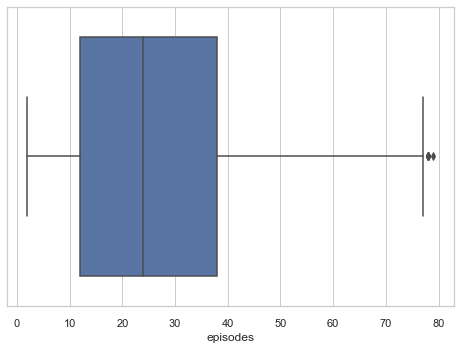

In [31]:
atr = 'episodes'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_series[atr])

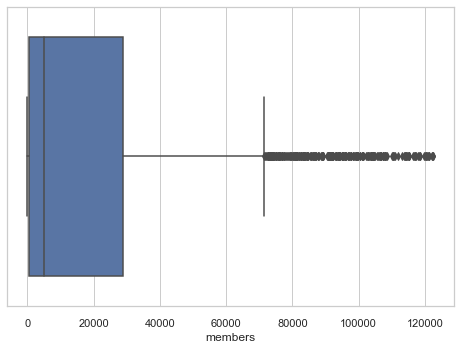

In [32]:
atr = 'members'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_series[atr])

### Dataframe para otro contenido (peliculas, ovas, etc)

In [33]:
q_low = df_other_content["episodes"].quantile(0.25)
q_hi  = df_other_content["episodes"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_other_content = df_other_content[(df_other_content["episodes"] < high) & (df_other_content["episodes"] > lower)]

In [34]:
q_low = df_other_content["members"].quantile(0.25)
q_hi  = df_other_content["members"].quantile(0.75)
iqr = q_hi - q_low

lower = q_low - (1.5*iqr)
high = q_hi + (1.5*iqr)

df_other_content = df_other_content[(df_other_content["members"] < high) & (df_other_content["members"] > lower)]

In [35]:
df_other_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6059 entries, 205 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  6059 non-null   int64  
 1   name      6059 non-null   string 
 2   genre     6059 non-null   string 
 3   type      6059 non-null   int32  
 4   episodes  6059 non-null   int32  
 5   rating    6059 non-null   float64
 6   members   6059 non-null   int64  
dtypes: float64(1), int32(2), int64(2), string(2)
memory usage: 331.4 KB


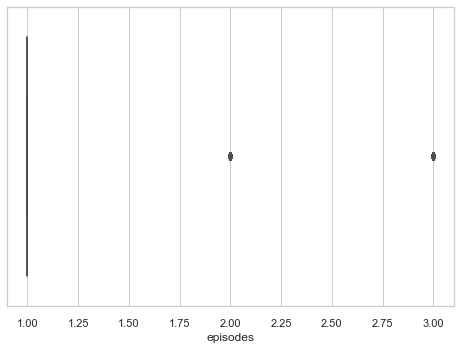

In [36]:
atr = 'episodes'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_other_content[atr])

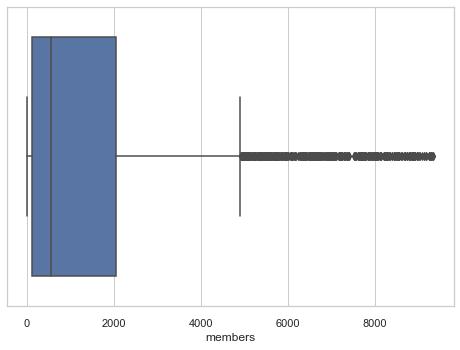

In [37]:
atr = 'members'
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_other_content[atr])

## Construccion del modelo de clustering

In [38]:
df_series_comparate = deepcopy(df_series[nombre_de_las_variables_de_entrada])
nombre_de_las_variables_de_entrada = ['episodes','rating','members']

rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_series_norm = deepcopy(df_series_comparate)  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_series_norm[nombre_de_las_variables_de_entrada] = scaler.fit_transform(df_series_norm) #Ajustamos y transformamos los datos.


NameError: name 'nombre_de_las_variables_de_entrada' is not defined

In [ ]:
ax = sns.heatmap(df_series_norm.corr(),annot=True,cmap='RdYlGn')

In [ ]:
sns.set(style='white')  #Esto fija el estilo del fondo. Algunas opciones son: 'dark', 'white'
sns.set_palette('Set2') #Para otras opciones de paletas de colores, visite: https://seaborn.pydata.org/tutorial/color_palettes.html
g = sns.PairGrid(data=df_series_norm.iloc[:,0:],diag_sharey=True)  #Note que no graficamos la columna 0 correspondiente a Id, 
                                                                     #pues no aporta información. Usamos las categorías de la columna de
                                                                     #'Species' para colorear las gráficas.
g.map_diag(sns.kdeplot)      #Muestra gráficos de densidad 1D en la diagonal de la matriz. 
g.map_lower(sns.scatterplot) #Muestra gráficos de dispersión en la sección inferior izquierda de la matriz.

g.add_legend()               #Agrega la leyenda de las especies.
plt.show()

In [ ]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


In [ ]:
df_x_norm = df_series_norm
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.2

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test = train_test_split(df_x_norm,                                         
                                        test_size=particion_para_pruebas, 
                                        random_state=valor_semilla_aleatoria, 
                                        shuffle=mezclar_los_datos)

In [ ]:
#Revisemos los resultados del método de la silueta para algunos valores
#"tentativos" para k:
silhouette_score_list        = []

for k in [2, 3, 4,5,6,7,8,9,10]:
    model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model3.fit(df_x_train)
    sc = silhouette_score(df_x_train.values, model3.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
    visualizer5.fit(df_x_train)
    visualizer5.show() 

In [ ]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

In [ ]:
#K-means
#-------------------------------------------------------------------------------
k = 3  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)

#Revisemos los centroides de cada grupo.
centroides = kmeans.cluster_centers_
print('Centroides:', centroides)